# Librerias

In [1]:
!pip3 install googletrans
!pip3 install emoji

In [2]:
# trabajar con datos tabulares
import pandas as pd
# nlp
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('word2vec_sample')
# guardado del modelo entranado
import joblib
# eliminar warning del replace
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# traducir
from googletrans import Translator
# emojis
import emoji
# enum
from enum import Enum

def is_running_on_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is alrea

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

class Modelos(Enum):
    LOGISTIC_REGRESSION = 'logistic_regression'
    DECISION_TREE = 'decision_tree'
    MULTINOMIAL = 'multinomial'
    BERNOULLI = 'bernoulli'
    GAUSIAN = 'gausian'

def select_model_to_train(model_name):
    models = {
        Modelos.LOGISTIC_REGRESSION.value: LogisticRegression(max_iter=1000),
        Modelos.DECISION_TREE.value : DecisionTreeClassifier(),
        Modelos.MULTINOMIAL.value : MultinomialNB(),
        Modelos.BERNOULLI.value: BernoulliNB(),
        Modelos.GAUSIAN.value: GaussianNB()
    }
    if model_name in models:
        return models[model_name]
    else:
        raise ValueError(f"Modelo '{model_name}' no válido")

# Funcion analizadora

In [4]:
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

# lematization
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


# Agrego a stopwords signos de puntuacion y emojis
stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))
# stopwords_en = set(stopwords_en).union(set(emoji.UNICODE_EMOJI['en']))

# Defino la funcion
def preprocessing_function(text):
    words = []

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en and not word_lemmatized.isdigit() and not emoji.purely_emoji(word_lemmatized):
            words.append(word_lemmatized)

    return words

# Funcion test

In [5]:
#Vamos a definir nuestra funcion de test y graficar nuestra confusion matrix.
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test(clf, nombreModelo):
  clf.fit(X_train_vectorized.toarray(), y_train)
  y_pred = clf.predict(X_test_vectorized.toarray())

  accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
  # Crear matriz de confusión y mostrarla
  disp = ConfusionMatrixDisplay.from_estimator(
        clf, X_test_vectorized.toarray(), y_test,  xticks_rotation="vertical"
   )
  
  # Añadir título a la matriz de confusión
  plt.title(nombreModelo + " - Accuracy: {:.2f}".format(accuracy))

  # Mostrar la matriz de confusión con el título
  # disp.plot()
  plt.show()

  return disp

# Importacion dataset

In [6]:
# Ruta del archivo CSV
cant_importada = 50000
path_base_dataset = '/content/' if is_running_on_colab() else '..\\datasets\\'
path_dataset =  path_base_dataset + 'Suicide_Detection.csv'

# Leer el archivo CSV en un DataFrame de Pandas, 
# dataframe = pd.read_csv(file_path)
# si quiero limitar la cantidad a importar
dataframe = pd.read_csv(path_dataset, nrows=cant_importada)

# Este caso puntual el csv la primera columna es el indice que no nos interesa, si quiero eliminarla por el nombre que le asigna pandas
# dataframe = dataframe.drop('Unnamed: 0', axis=1)
# o eliminarla por la posicion
dataframe = dataframe.drop(dataframe.columns[0], axis=1)

# Paso a booleano la clasificacion
dataframe['class'] = dataframe['class'].replace({"suicide": True, "non-suicide": False})

print(dataframe)

                                                    text  class
0      Ex Wife Threatening SuicideRecently I left my ...   True
1      Am I weird I don't get affected by compliments...  False
2      Finally 2020 is almost over... So I can never ...  False
3              i need helpjust help me im crying so hard   True
4      I’m so lostHello, my name is Adam (16) and I’v...   True
...                                                  ...    ...
49995  I think i figured it out So when i was with my...  False
49996  Quarantine and ruminatingWith this pandemic an...   True
49997  I have a theory The Democrats master plan:\n\n...  False
49998  I want to die but I dont want to be selfishI k...   True
49999  Is wanting to die the same as being suicidal? ...   True

[50000 rows x 2 columns]


# Entrenamiento con vectorizador

In [7]:
# Hacemos un split de sets de train y test
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dataframe["text"],
                                                    dataframe["class"],
                                                    test_size=0.15, random_state=0,
                                                    stratify=dataframe["class"])

len(y_train), len(y_test)

(42500, 7500)

In [8]:
# Sklearn tiene un objeto llamado CountVectorizer que nos permite pasarle un "analyzer"
# El "analyzer" toma el texto que le pasamos y devuelve una lista de palabras a contar.

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(analyzer=preprocessing_function)

# Entrenamos nuestro CountVectorizer en el training set and transformamos ambos datasets
X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

# Entrenamiento y Guardado

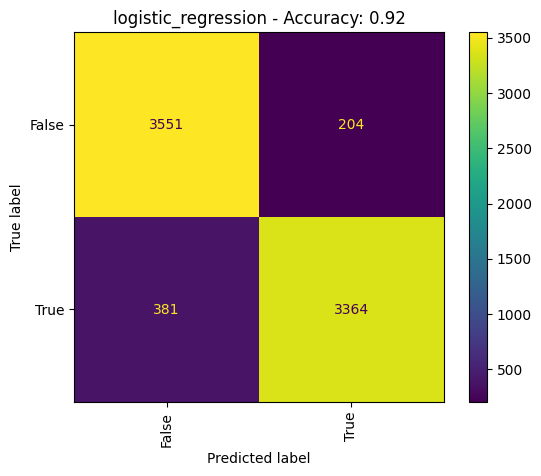

Modelo logistic_regression guardado en ..\entrenados\logistic_regression_50k
--------------------------------


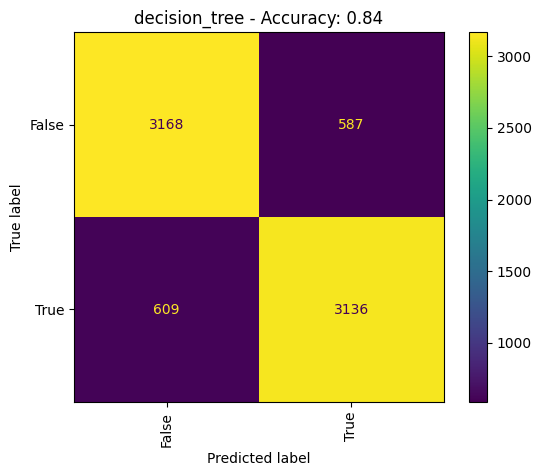

Modelo decision_tree guardado en ..\entrenados\decision_tree_50k
--------------------------------


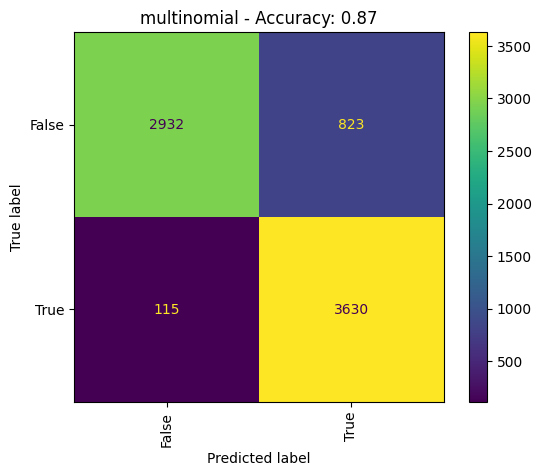

Modelo multinomial guardado en ..\entrenados\multinomial_50k
--------------------------------


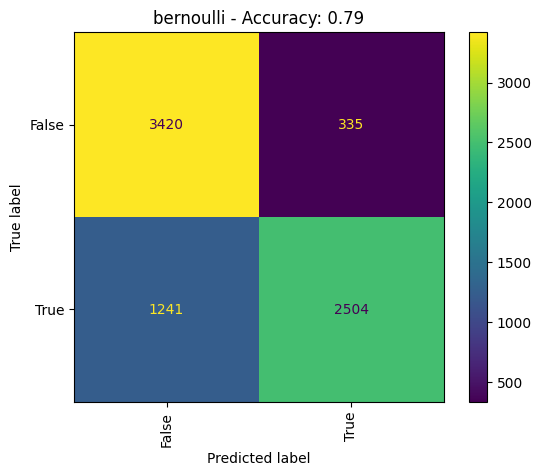

Modelo bernoulli guardado en ..\entrenados\bernoulli_50k
--------------------------------


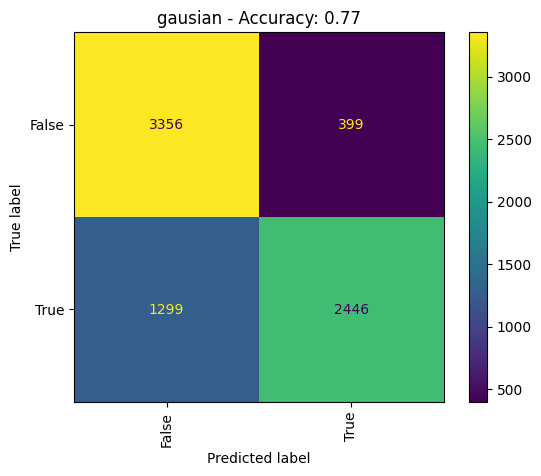

Modelo gausian guardado en ..\entrenados\gausian_50k
--------------------------------


In [9]:
# Definir que entrenar
# modelo, entrenar?
modelos_disponibles = {
    Modelos.LOGISTIC_REGRESSION.value : True,
    Modelos.DECISION_TREE.value: True,
    Modelos.MULTINOMIAL.value: True,
    Modelos.BERNOULLI.value: True,
    Modelos.GAUSIAN.value: True,
}

cant_entrenada_str = "{:.0f}".format(cant_importada/1000) + 'k'

for nombreModelo, entrenar in modelos_disponibles.items():
    if entrenar:
        modelToTrain = select_model_to_train(nombreModelo)
        test(modelToTrain, nombreModelo)

        path_base_modelo = '/content/' if is_running_on_colab() else '..\\entrenados\\'
        path_modelo = path_base_modelo + nombreModelo + '_' + cant_entrenada_str
        joblib.dump(modelToTrain, path_modelo +  '_model.pkl')
        joblib.dump(count_vectorizer, path_modelo + '_vector.pkl')
        print(f"Modelo {nombreModelo} guardado en " + path_modelo)
        modelToTrain = None
    else:
        print(f"Modelo {nombreModelo} no entrenado")
    print("--------------------------------")

# Casos de uso

## Cargar modelo previamente generado

In [ ]:
nombre_modelo_prev_entrenado = Modelos.DECISION_TREE.value
# usar formato '25k' para 25.000 filas ejemplo
cant_prev_entrenada = '1k'

path_base_modelo_generado = '/content/' if is_running_on_colab() else '..\\entrenados\\'
path_modelo_generado = path_base_modelo_generado + nombre_modelo_prev_entrenado + '_' + cant_prev_entrenada

loaded_model = joblib.load(path_modelo_generado + '_model.pkl')
loaded_count_vectorizer = joblib.load(path_modelo_generado + '_vector.pkl')

vect = loaded_count_vectorizer
model = loaded_model

print(type(model))
print(model.n_features_in_)


## Probar con dataset

In [ ]:

path_base_dataset = '/content/' if is_running_on_colab() else '..\\datasets\\'
path_dataset =  path_base_dataset + 'Suicide_Detection.csv'

cant_a_probar = 5000

dataframeTest = pd.read_csv(path_dataset, skiprows=50000, nrows=cant_a_probar)
dataframeTest.columns = ["borrar","text","class"]
dataframeTest = dataframeTest.drop("borrar", axis=1)
dataframeTest['class'] = dataframeTest['class'].replace({"suicide": True, "non-suicide": False})

print(dataframeTest)

In [ ]:
counter = 0

for index, row in dataframeTest.iterrows():
    texto = row['text']
    
    # translator = Translator()
    # traduccion = translator.translate(texto, dest='es').text

    texto_preprocesado = preprocessing_function(texto)
    texto_preprocesado_str = ' '.join(texto_preprocesado)

    texto_vectorizado = vect.transform([texto_preprocesado_str])

    prediccion = model.predict(texto_vectorizado)

    clase_real = row['class']
    resultado_prediccion = 'suicida' if prediccion else 'no suicida'
    resultado_real = 'suicida' if clase_real else 'no suicida'

    if resultado_real != resultado_prediccion :
        counter = counter + 1
    #     print("----------------")
    #     print(texto)
    #     print("Dato dataset " + resultado_real)
    #     print("Dato prediccion " + resultado_prediccion)

print("La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: " + str(counter) + " - " + str("{:.2f}".format(cant_a_probar / counter) if counter != 0 else "no hubo errores") + "%")


## Probar con nuestro datos

In [ ]:
textos_prueba = [
                "I want to jump from a bridge",
                "I want to suicide me",
                 "I hate my parents with all my heart",
                 "I hate all about this life",
                 "I cry every night",
                 "I don't know what is happen to me, but I don't want live anymore"
                 ]

translator = Translator()

for texto in textos_prueba:
    traduccion = translator.translate(texto, dest='es').text

    texto_preprocesado = preprocessing_function(texto)
    texto_preprocesado_str = ' '.join(texto_preprocesado)

    # decision tree
    texto_vectorizado = vect.transform([texto_preprocesado_str])

    prediccion = model.predict(texto_vectorizado)

    print(f"'{texto}'\n'{traduccion}'\n{'suicida' if prediccion else 'no suicida'}\n\n")

# Verificar ocurrencia de palabras

## Palabras mas comunes contando palabra por palabra

In [ ]:
# Intuición principal en este tipo de tecnicas: Contar las ocurrencias de las palabras.
from collections import defaultdict, Counter
from tqdm import tqdm

# Instanciamos un contador de python
word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1]

    # Usamos la funcion implementada en pandas split() para separar palabras por espacios en blanco.
    for word in text.str.split()[0]:
        word_counts[word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(25)

## Palabras mas comunes contando con tokenizador

In [ ]:
from nltk import word_tokenize

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in word_tokenize(text):
        word_counts[word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(25)

In [ ]:
print(("hello, how are you?").split())

In [ ]:
print(word_tokenize("hello, how are you?"))

## Palabras mas comunes contando teniendo en cuenta stopwords

In [ ]:
stopwords_en = stopwords.words('english')
print(stopwords_en)

In [ ]:
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

## Palabras mas comunes contando teniendo en cuenta signos de puntuacion

In [ ]:
from string import punctuation

# Hacemos una union entre conjunto de caracteres de puntuacion nativos a nuestro conjunto de stopwords usando la operation union de sets de datos.
stopwords_en = set(stopwords_en).union(set(punctuation))

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

## Stemming

In [ ]:
# Usamos Stemming
from nltk.stem import PorterStemmer

porter = PorterStemmer()

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            stemmed_word = porter.stem(word_lowercase)
            word_counts[stemmed_word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

## Lematization

In [ ]:
#Usemos Lemmatization:
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer


wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en:
            word_counts[word_lemmatized] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

# Entrenamientos por clasificador

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
test(dtc)

### MultinomialBN

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
test(mnb)

### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
test(bnb)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# lgr = LogisticRegression()
lgr = LogisticRegression(max_iter=1000)
test(lgr)

### Gaussian

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
test(gnb)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=42)
test(clf)